# Importing

In [1]:
import json
import math
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from PIL import Image
import os
import scipy
import seaborn as sns
import skimage
import torch

from xd.metrics import ssim, feature_agreement, sign_agreement, rank_correlation, normalize
from xd.disagreement import compute_heatmaps
import utils

# Configurations

In [2]:
# Select environment
DATASET_PATH, CHECKPOINT_PATH = utils.get_path('local')

print(f'Dataset path: {DATASET_PATH}')
print(f'Checkpoint path: {CHECKPOINT_PATH}')

Dataset path: ../datasets/
Checkpoint path: pretrained_weights/


# Load from saved explanations

In [3]:
explanations = dict()
blackboxes = utils.BLACK_BOX_NAMES
methods = utils.METHOD_NAMES

for blackbox in blackboxes:
    explanations[blackbox] = dict()
    
    directory = os.path.join(utils.SAVED_EXPLANATIONS_DIR, 'Pneumothorax', blackbox)
    for file in os.listdir(directory):
        method = os.path.basename(file).split('.')[0]
        path = os.path.join(directory, file)
        exp = torch.load(path)

        explanations[blackbox][method] = exp

print(f'Blackboxes: {blackboxes}')
print(f'Methods: {methods}')

Blackboxes: ['InceptionV3', 'ResNet']
Methods: ['DeepLift', 'GradientShap', 'GuidedBackprop', 'GuidedGradCam', 'IntegratedGradients', 'LRP', 'Occlusion', 'Saliency']


# Visualizing

In [4]:
def visualize(hm, title='', ax=None, **options):
    return sns.heatmap(
        hm,
        annot=True,
        ax=ax,
        **options
    ).set(title=title)

In [5]:
def get_annot_array(data: np.ndarray):
    str_array = np.char.mod('%.2f', data)
    str_array[str_array == 'nan'] = '-'
    return str_array

In [6]:
def visualize_many(heatmaps, metric_name='', **options):
    num_black_boxes = len(heatmaps.keys())
    fig, axes = plt.subplots(nrows=1, ncols=num_black_boxes, figsize=(18,6))
    
    if num_black_boxes == 1:
        axes = [axes]
    
    for i, blackbox in enumerate(heatmaps.keys()):
        heatmap_dict = heatmaps[blackbox]
        methods = heatmap_dict['methods']
        data = heatmap_dict['data']
        
        annot = get_annot_array(data)
        data[np.isnan(data)] = 0
        
        # Plot
        sns.heatmap(
            data,
            annot=annot,
            ax=axes[i],
            xticklabels=methods,
            yticklabels=methods,
            fmt='',
            **options
        ).set(title=blackbox)
        axes[i].tick_params(left=False, bottom=False)
    
    fig.suptitle(metric_name)
    return fig, axes

In [7]:
def visualize_many_with_k(map_k_and_heatmaps, ks, metric_name='', **options):
    rows, cols = len(ks), 2
    fig, axes = plt.subplots(rows, cols, figsize=(18, 22))
    cbar_ax = fig.add_axes([.91, .4, .015, .23])
    
    # For common legend
    handles, labels = None, None
    for row, k in enumerate(ks):
        heatmaps = map_k_and_heatmaps[k]
        
        for col, blackbox in enumerate(heatmaps.keys()):
            # Get methods and heatmaps
            heatmap_dict = heatmaps[blackbox]
            methods = heatmap_dict['methods']
            data = heatmap_dict['data'].copy()
            
            annot = get_annot_array(data)
            data[np.isnan(data)] = 0
            
            # Plot
            ax = axes[row][col]
            sns.heatmap(
                data=data,
                annot=annot,
                ax=ax,
                xticklabels=methods,
                yticklabels=methods,
                fmt='',
                cbar_ax=cbar_ax,
                **options
            ).set(title=f'{blackbox} (k={k})')
            ax.tick_params(left=False, bottom=False)
    
    fig.suptitle(metric_name)
    fig.tight_layout(rect=[0, 0, .9, 1], pad=2)
    return fig, axes

In [8]:
def get_top_k(exp, k):
    _, top = torch.topk(exp.flatten().abs(), k)
    old_size = exp.size()
    result = torch.zeros(exp.nelement())
    result[top] = 1
    result = result.reshape(old_size).bool()
    return result

## Feature Agreement

In [9]:
percentages = [0.05, 0.1, 0.2]
num_pixels = 128 * 128
ks = list(map(lambda p: int(num_pixels * p), percentages))

In [10]:
%%time
heatmap_fa = dict()
for k in ks:
    heatmap_fa[k] = compute_heatmaps(explanations, metric=feature_agreement, k=k)

CPU times: total: 3.33 s
Wall time: 3.47 s


C:\Users\mdnam\AppData\Local\Temp\ipykernel_17892\1659645060.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=2)


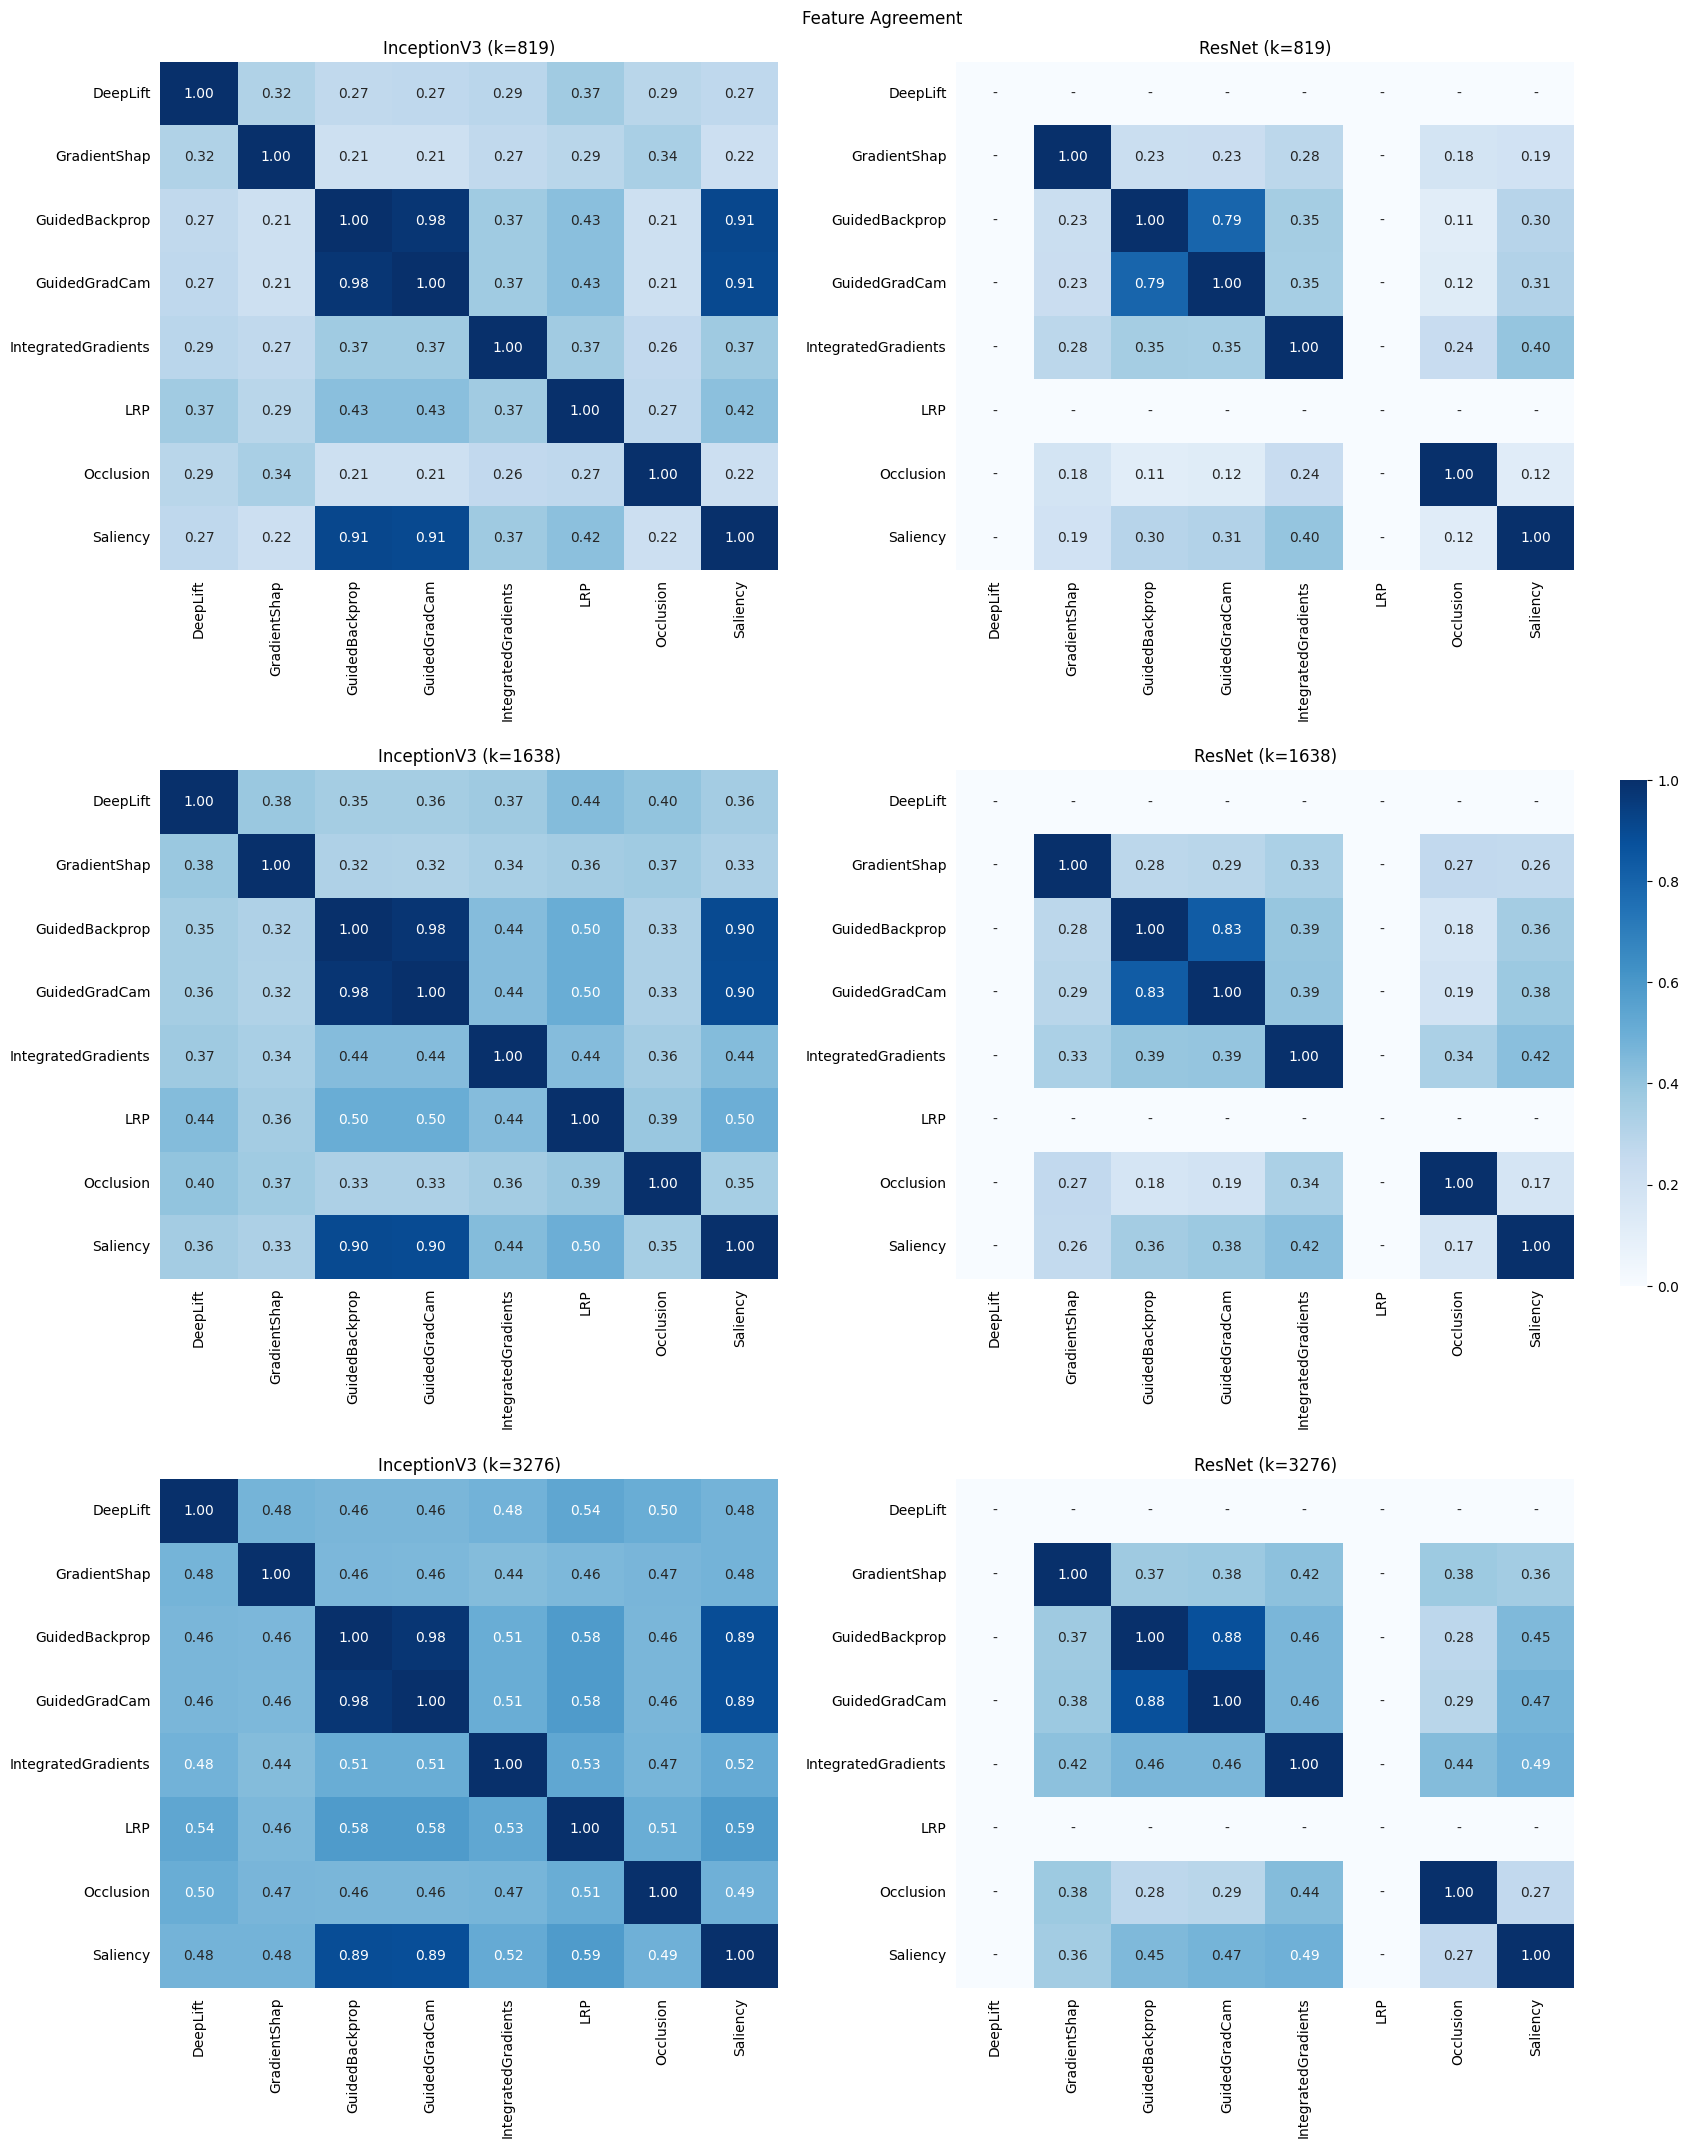

In [11]:
options = {
    'vmin': 0,
    'vmax': 1,
    'cmap': 'Blues'
}

fig_fa, axes_fa = visualize_many_with_k(heatmap_fa, ks, metric_name='Feature Agreement', **options)
fig_fa.savefig(os.path.join(utils.FIGURES_PATH, 'feature-agreement'), bbox_inches='tight')
plt.show()

## Sign Agreement

In [12]:
%%time
heatmap_sa = dict()
for k in ks:
    heatmap_sa[k] = compute_heatmaps(explanations, metric=sign_agreement, k=k)

CPU times: total: 5.03 s
Wall time: 5.23 s


C:\Users\mdnam\AppData\Local\Temp\ipykernel_17892\1659645060.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=2)


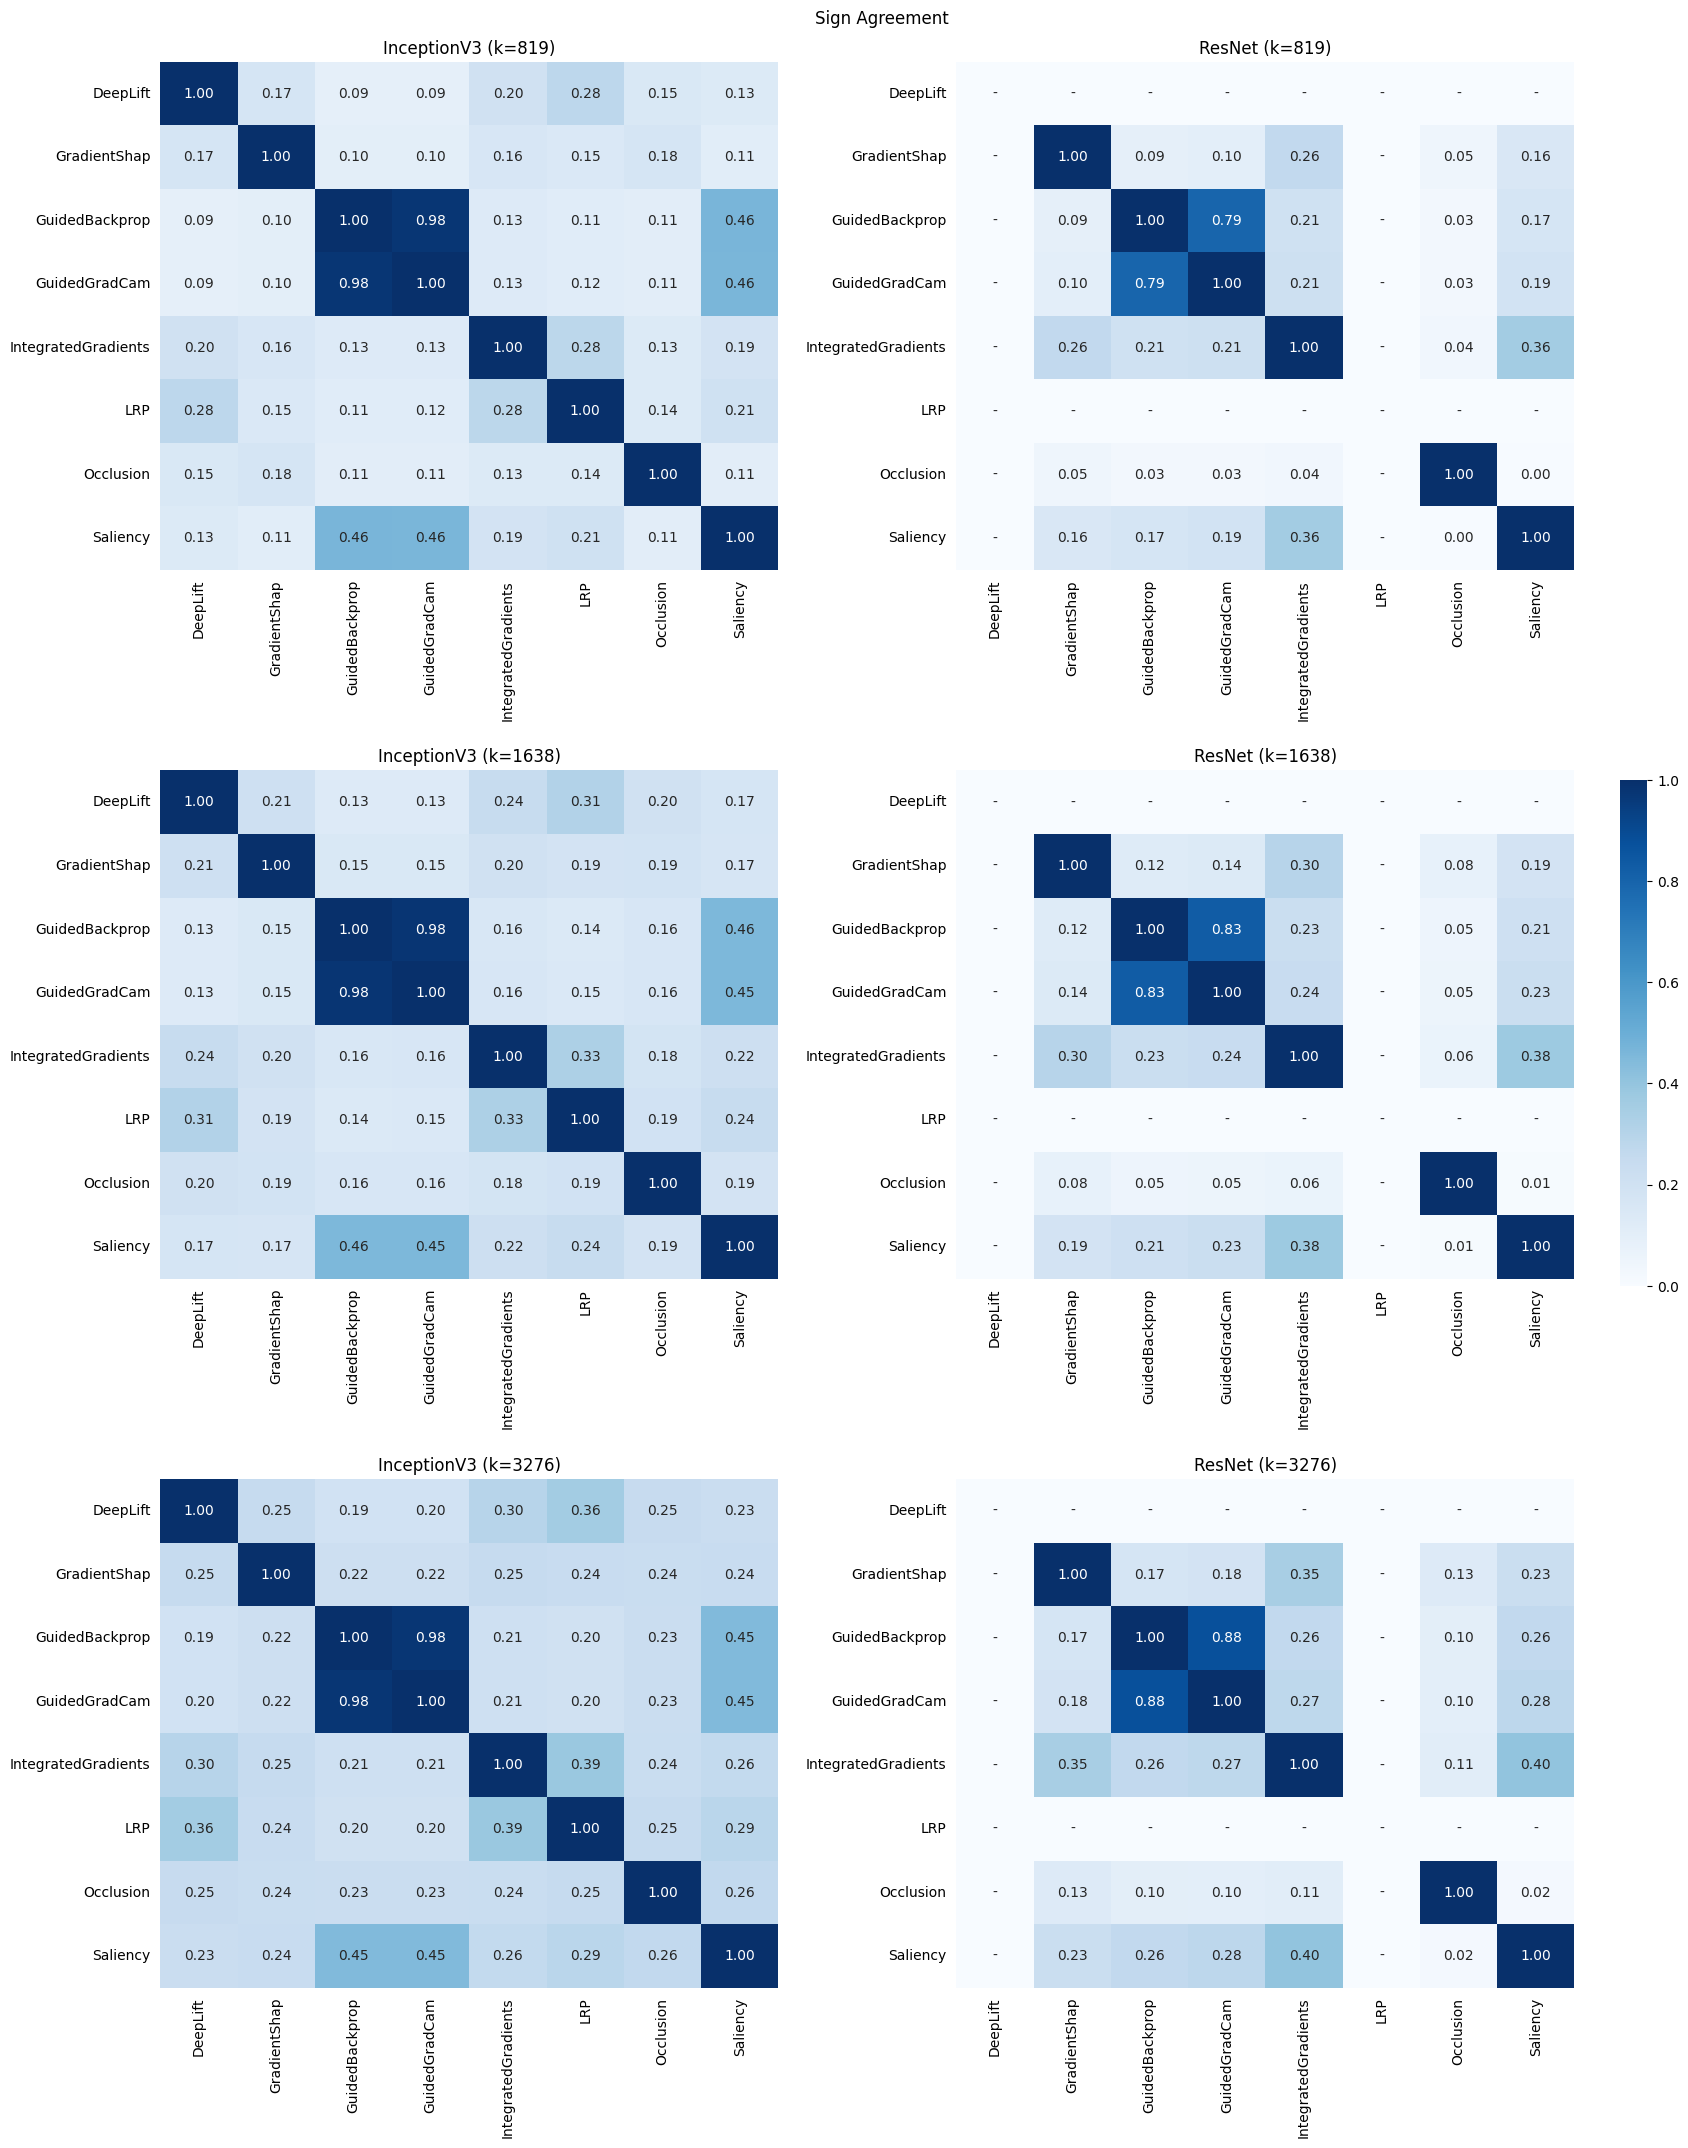

In [13]:
fig_sa, axes_as = visualize_many_with_k(heatmap_sa, ks, metric_name='Sign Agreement', **options)
fig_sa.savefig(os.path.join(utils.FIGURES_PATH, 'sign-agreement'), bbox_inches='tight')
plt.show()

## Ratio between feature agreement and sign agreement

In [14]:
heatmap_div = dict()
for k in ks:
    heatmap_div[k] = dict()
    for blackbox in blackboxes:
        heatmap_div[k][blackbox] = dict()
        methods = heatmap_fa[k][blackbox]['methods']
        heatmap_div[k][blackbox]['methods'] = methods
        
        fa = heatmap_fa[k][blackbox]['data']
        sa = heatmap_sa[k][blackbox]['data']
        heatmap_div[k][blackbox]['data'] = fa / sa

C:\Users\mdnam\AppData\Local\Temp\ipykernel_17892\1659645060.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=2)


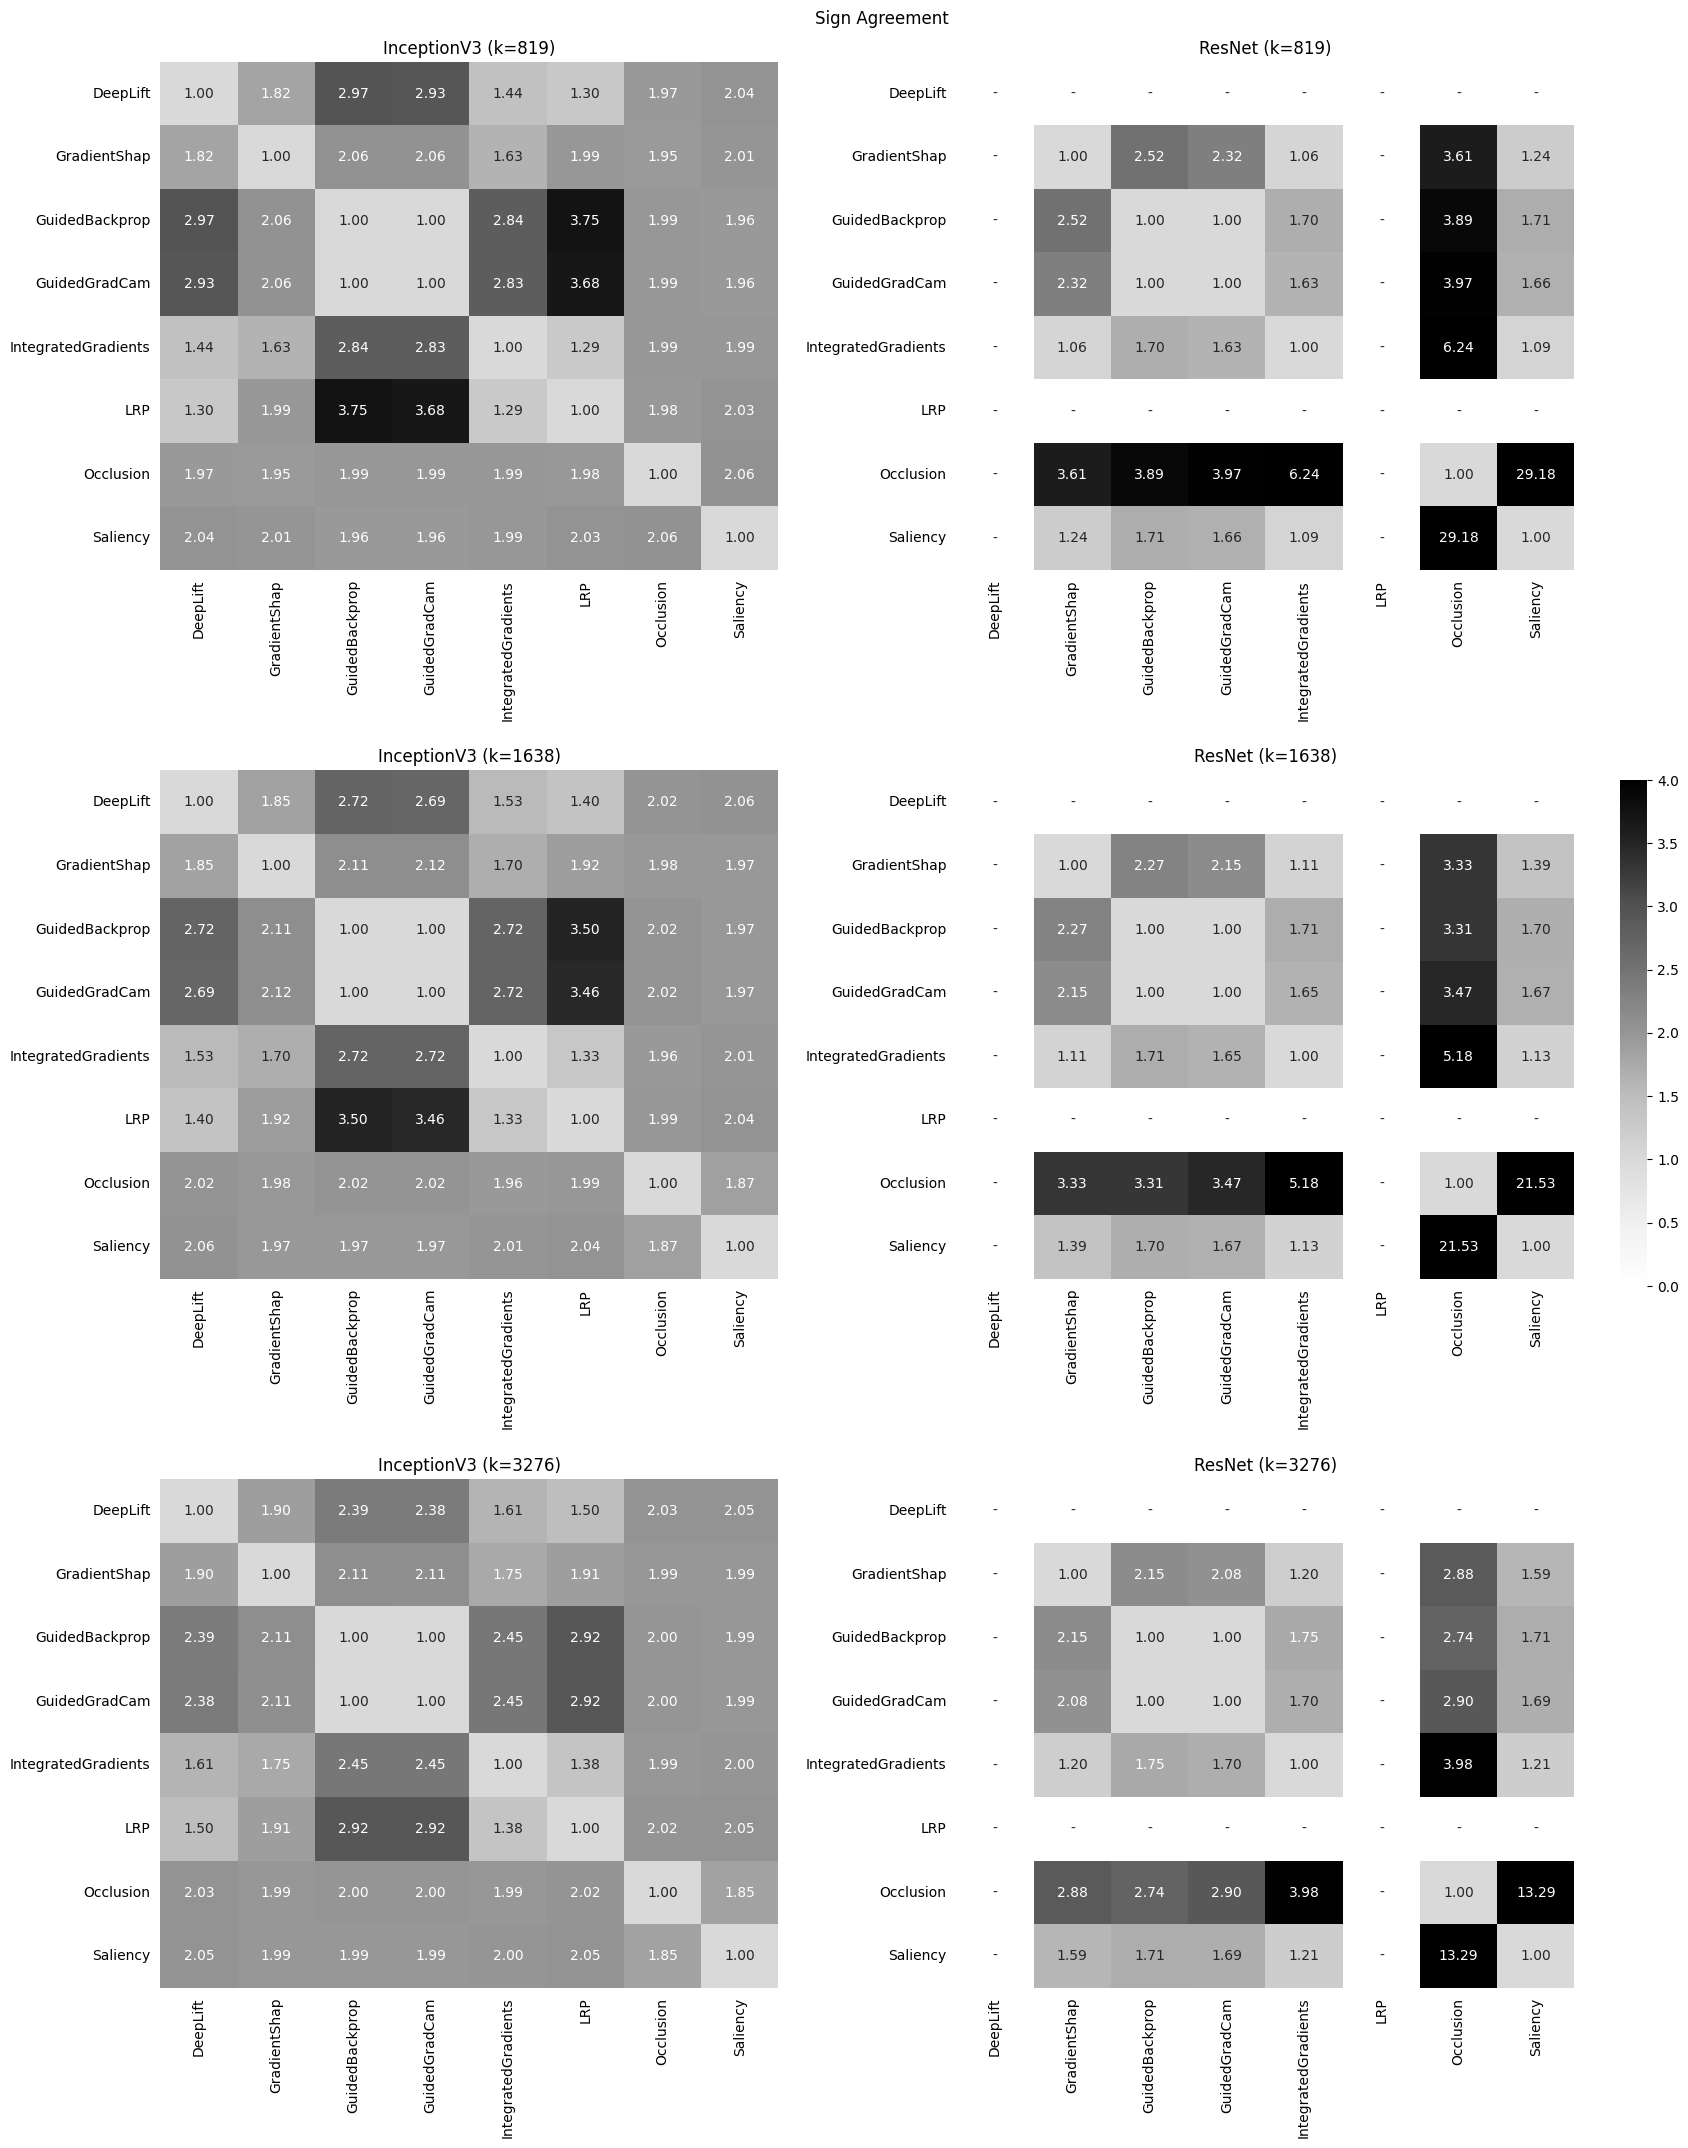

In [15]:
fig_ratio, _ = visualize_many_with_k(heatmap_div, ks, metric_name='Sign Agreement', **{'vmin': 0, 'vmax': 4, 'cmap': 'Greys'})
fig_ratio.savefig(os.path.join(utils.FIGURES_PATH, 'ratio-fa-sa'), bbox_inches='tight')
plt.show()

## Rank correlation

In [16]:
with open(os.path.join(utils.SAVED_EXPLANATIONS_DIR, 'test_files.json'), 'r') as f:
    test_files = json.load(f)

masks = list(map(
    lambda x: utils.mask_transform(Image.open(os.path.join(DATASET_PATH, 'pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax', 'png_masks', x)).convert('RGB'))[0, :, :].unsqueeze(0), 
    test_files
))

masks = torch.concat(masks)

c:\Users\mdnam\.local\opt\miniconda\envs\xai_disagreement\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [17]:
explanations_masked = dict()
masks_flatten = masks.flatten(1).bool()
for blackbox, v in explanations.items():
    explanations_masked[blackbox] = dict()
    
    for method in methods:
        exp = v[method]
        masked_explanations = []
        for i, e in enumerate(exp):
            mask = masks[i].bool()
            if mask.sum() == 0:
                continue
            masked_explanation = e[mask]
            masked_explanations.append(masked_explanation)
        explanations_masked[blackbox][method] = masked_explanations

In [18]:
%%time
heatmap_rc = compute_heatmaps(explanations_masked, metric=rank_correlation)

CPU times: total: 188 ms
Wall time: 83.5 ms


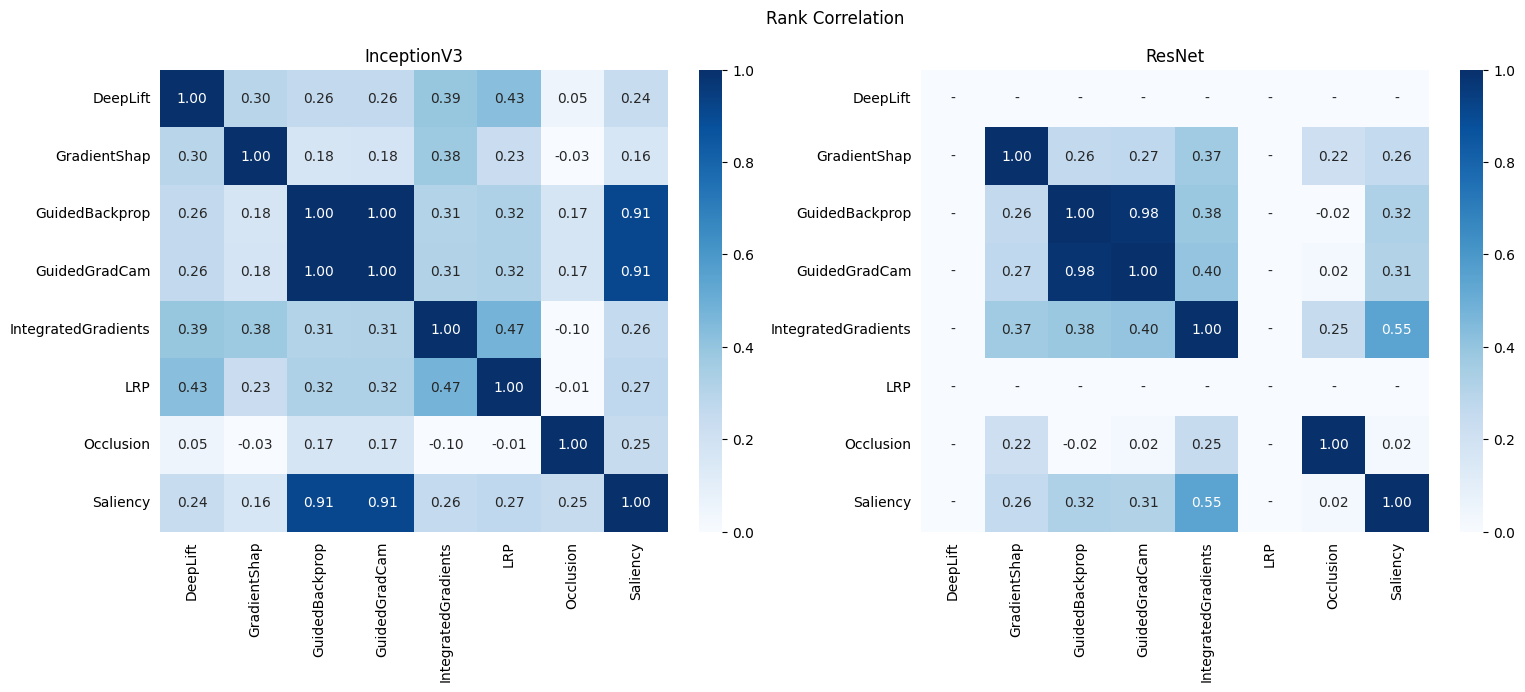

In [19]:
fig_rc, _ = visualize_many(heatmap_rc, metric_name='Rank Correlation', **options)
fig_rc.savefig(os.path.join(utils.FIGURES_PATH, 'rank-correlation'), bbox_inches='tight')
plt.show()

## SSIM

In [20]:
%%time
heatmap_ssim = compute_heatmaps(explanations, metric=ssim)

CPU times: total: 531 ms
Wall time: 572 ms


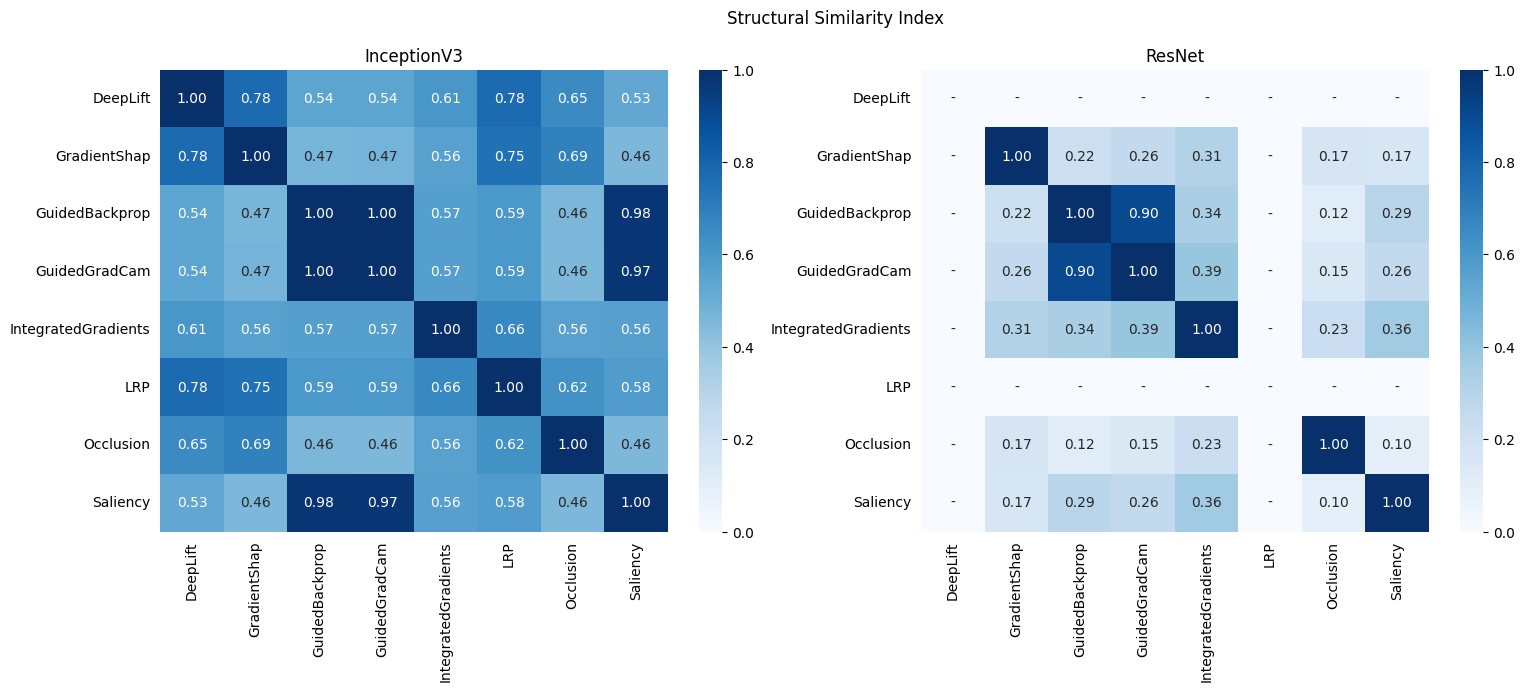

In [21]:
fig_ssim, axes_ssim = visualize_many(heatmap_ssim, metric_name='Structural Similarity Index', **options)
fig_ssim.savefig(os.path.join(utils.FIGURES_PATH, 'ssim'), bbox_inches='tight')
plt.show()

# Visualize sample of saliency maps

In [22]:
def get_image_as_tensor(filename):
    return utils.mask_transform(Image.open(os.path.join(DATASET_PATH, 'pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax', 'png_images', filename)).convert('RGB'))

In [23]:
def visualize_sample_saliency(test_files, masks, explanations, blackbox, methods, index):
    num_methods = len(methods)
    row, col = 2, math.ceil(num_methods / 2) + 1
    fig, axes = plt.subplots(row, col, figsize=(26, 10))
    
    axes[0][0].imshow(get_image_as_tensor(test_files[index]).permute(1, 2, 0))
    axes[1][0].imshow(masks[index], cmap='gray')
    
    for i, m in enumerate(methods):
        p = sns.heatmap(
            normalize(explanations[blackbox][m][index].abs().detach().numpy()),
            ax=axes[(i + 1) // col][1 + (i % (col-1))],
            annot=False,
            cbar=False,
            cmap='viridis'
        ).set(
            xticklabels=[],
            yticklabels=[],
            title=m
        )

        plt.legend([], [], frameon=False)

    for i, ax in enumerate(axes.flat):
        ax.tick_params(axis='both', which='both', bottom=False, top=False)
        ax.set_xticks([])
        ax.set_yticks([])
        if i >= num_methods:
            ax.axis('off')
        
    return fig, axes

c:\Users\mdnam\.local\opt\miniconda\envs\xai_disagreement\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


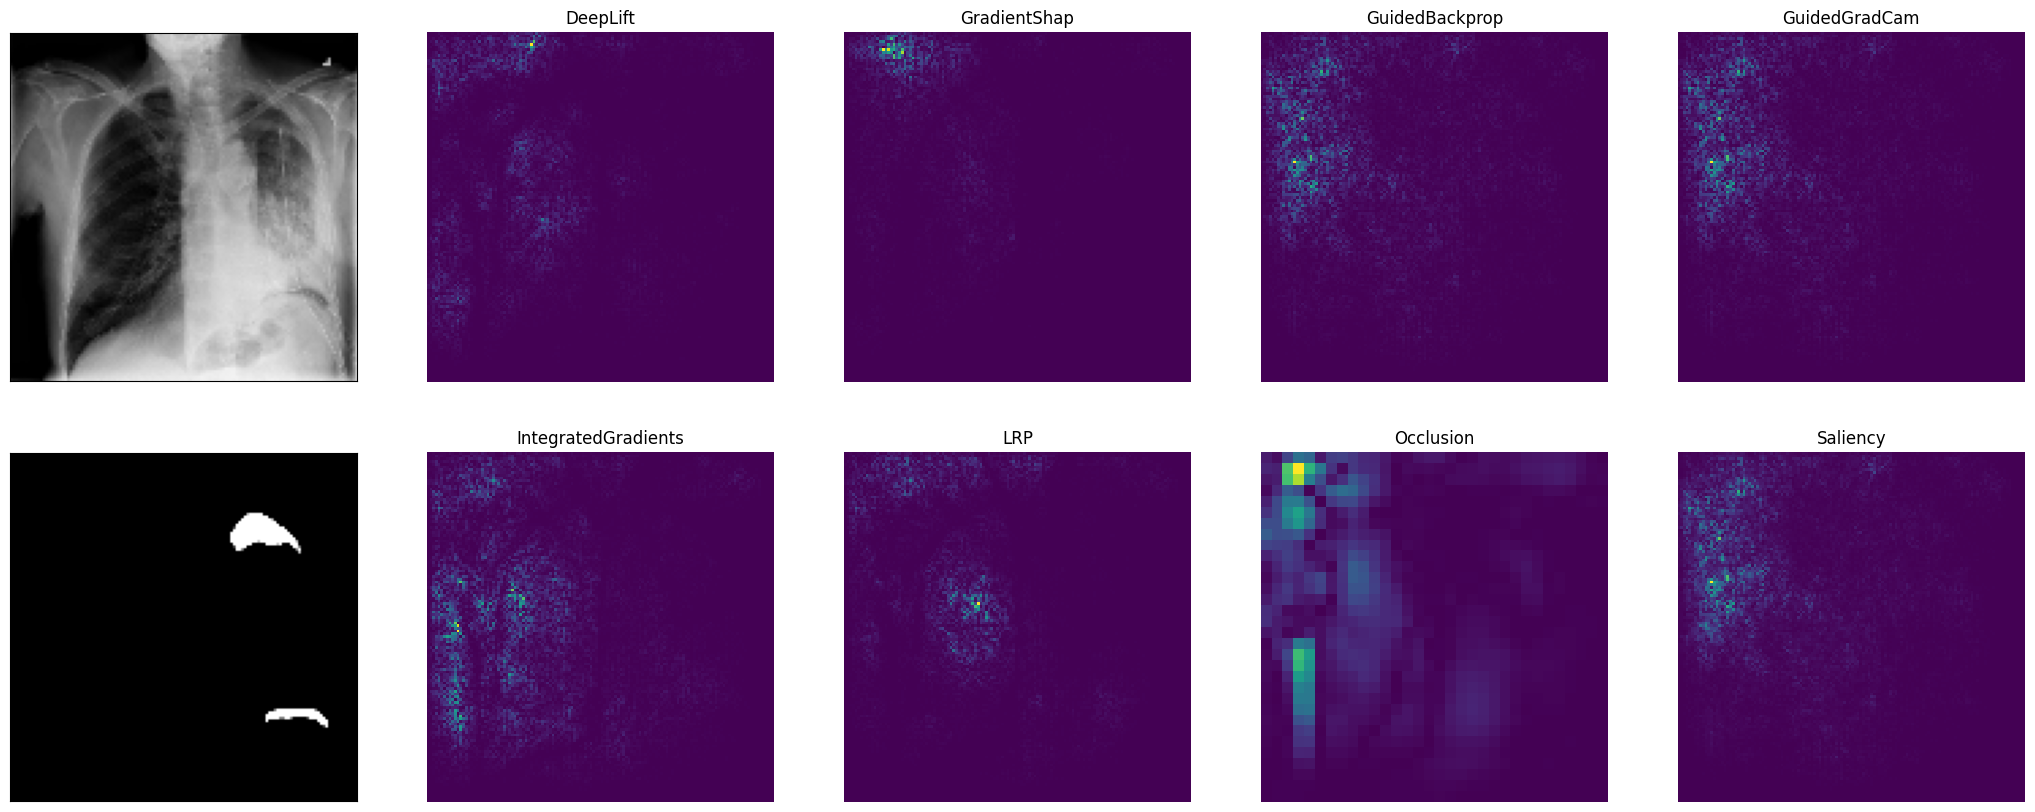

In [24]:
fig_inceptionv3, _ = visualize_sample_saliency(test_files, masks, explanations, 'InceptionV3', methods, 0)
fig_inceptionv3.savefig(os.path.join(utils.FIGURES_PATH, 'shape-comparison-inceptionv3.png'), bbox_inches='tight')
plt.show()

c:\Users\mdnam\.local\opt\miniconda\envs\xai_disagreement\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\mdnam\.local\opt\miniconda\envs\xai_disagreement\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\mdnam\.local\opt\miniconda\envs\xai_disagreement\lib\site-packages\se

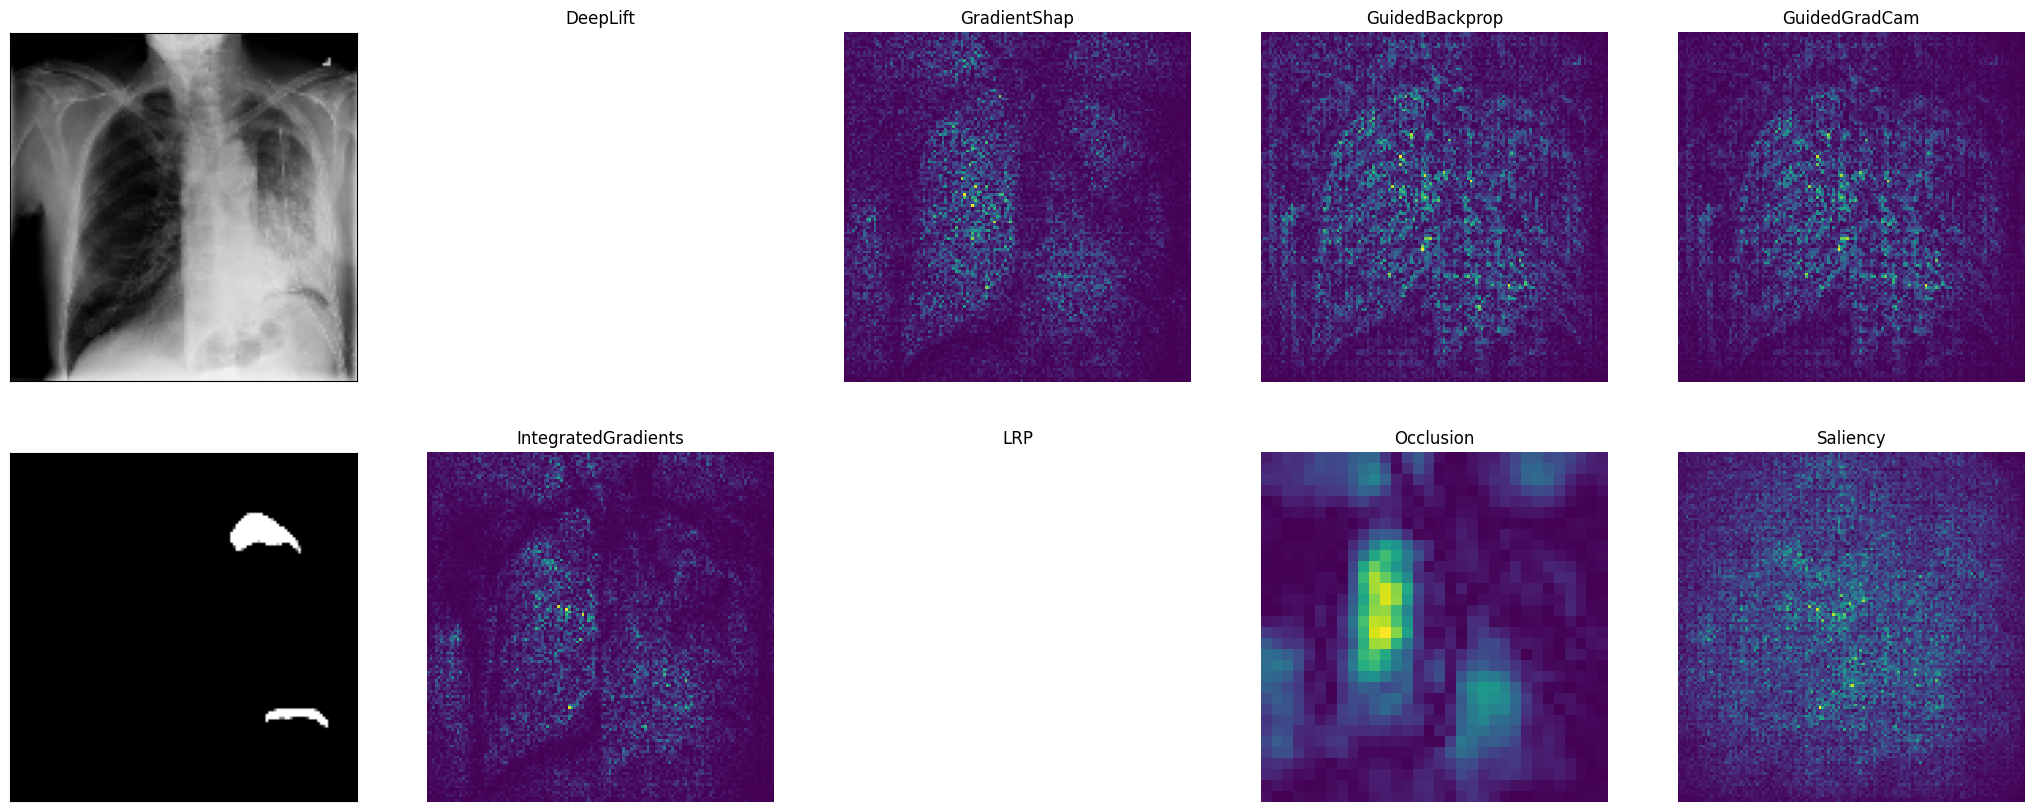

In [25]:
fig_resnet, _ = visualize_sample_saliency(test_files, masks, explanations, 'ResNet', methods, 0)
fig_resnet.savefig(os.path.join(utils.FIGURES_PATH, 'shape-comparison-resnet.png'), bbox_inches='tight')
plt.show()

# Visualize saliency maps value distribution

In [26]:
def plot_saliency_distribution(explanations, blackbox, methods):
    num_methods = len(methods)
    fig, axes = plt.subplots(4, 2, figsize=(8, 10), sharey=True)
    fig.tight_layout(w_pad=1, h_pad=1.5)
    
    for i, ax in enumerate(axes.flat):
        if i >= num_methods:
            ax.axis('off')
            continue

        topk = explanations[blackbox][methods[i]]
        topk = topk[get_top_k(topk, 1000)]
        sns.histplot(topk.numpy(), ax=ax).set(title=methods[i])
        
    return fig, axes

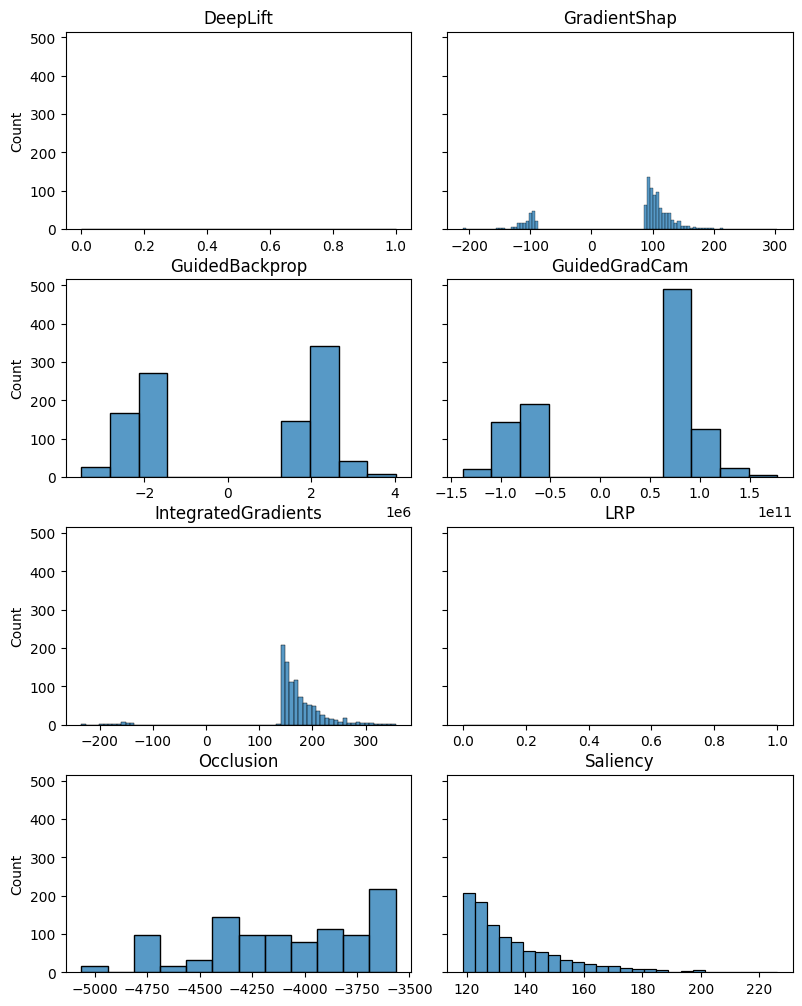

In [27]:
fig_dis_resnet, _ = plot_saliency_distribution(explanations, 'ResNet', methods)
fig_dis_resnet.savefig(os.path.join(utils.FIGURES_PATH, 'saliency-maps-value-distribution-resnet.png'), bbox_inches='tight')
plt.show()

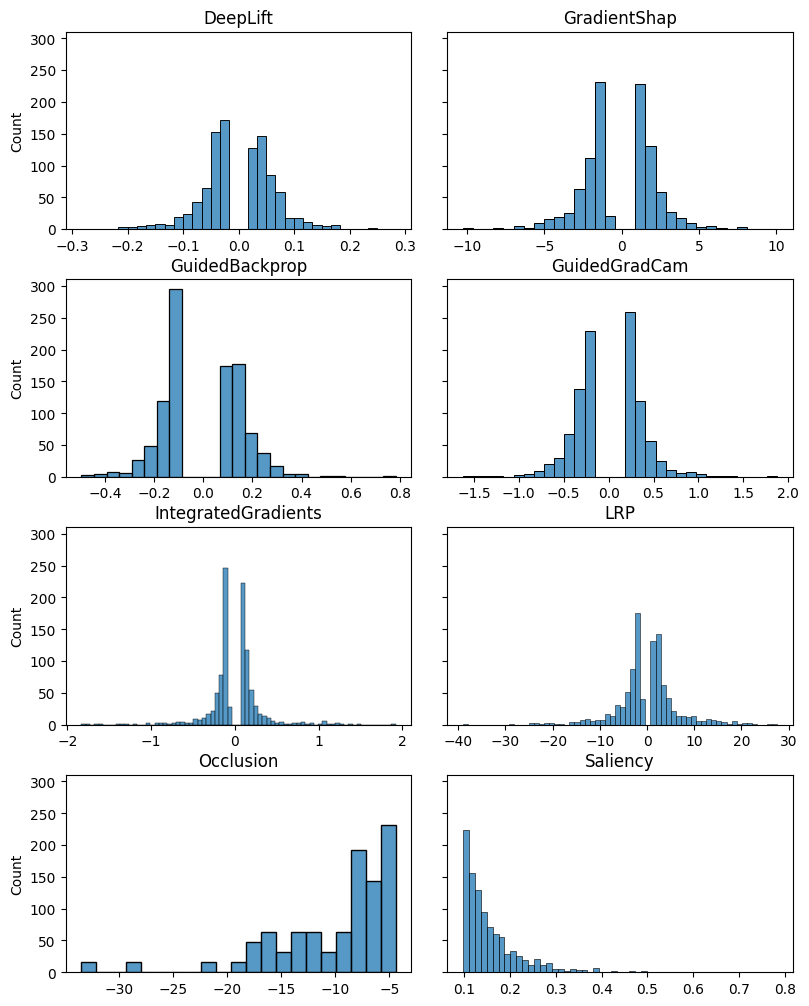

In [28]:
fig_dis_inceptionv3, _ = plot_saliency_distribution(explanations, 'InceptionV3', methods)
fig_dis_inceptionv3.savefig(os.path.join(utils.FIGURES_PATH, 'saliency-maps-value-distribution-inceptionv3.png'), bbox_inches='tight')
plt.show()

# Visualize for metric demonstration

In [29]:
method1, method2 = 'IntegratedGradients', 'GuidedBackprop'
example_index = 0

a = explanations['InceptionV3'][method1][example_index]
b = explanations['InceptionV3'][method2][example_index]

k = 820
top_a = get_top_k(a.abs(), k)
top_b = get_top_k(b.abs(), k)

In [30]:
def plot(exp):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(exp)
    ax.axis('off')
    return fig, ax

c:\Users\mdnam\.local\opt\miniconda\envs\xai_disagreement\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


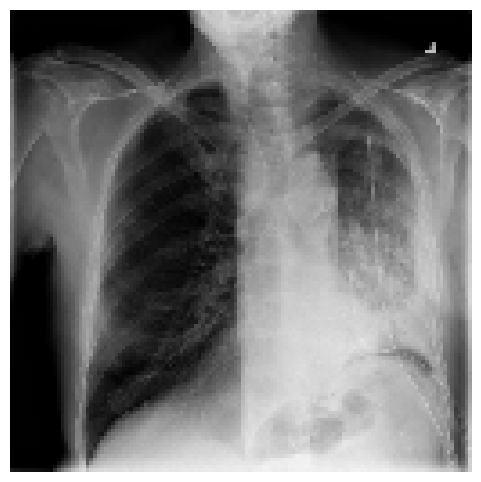

In [31]:
fig_inp, _ = plot(get_image_as_tensor(test_files[example_index]).permute(1, 2, 0))
fig_inp.savefig(os.path.join(utils.FIGURES_PATH, 'demo_fa/input'))

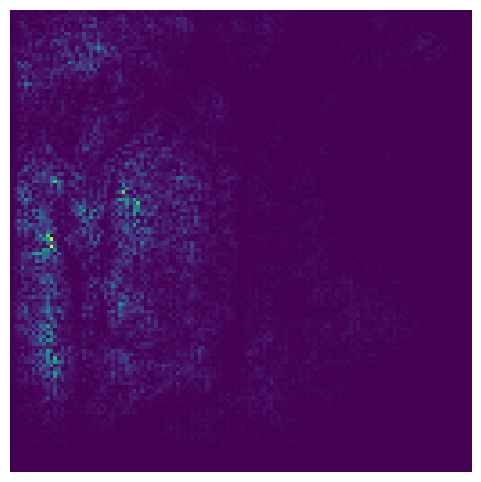

In [32]:
fig1, ax1 = plot(a.abs())
fig1.savefig(os.path.join(utils.FIGURES_PATH, f'demo_fa/{method1}'), bbox_inches='tight')

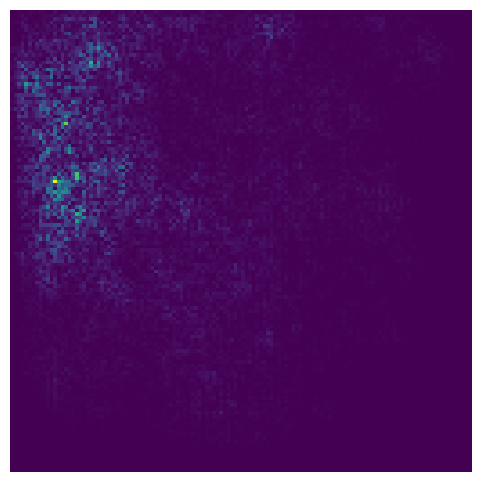

In [33]:
fig2, ax2 = plot(b.abs())
fig2.savefig(os.path.join(utils.FIGURES_PATH, f'demo_fa/{method2}'), bbox_inches='tight')

In [34]:
def get_extent(fig, ax):
    return ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

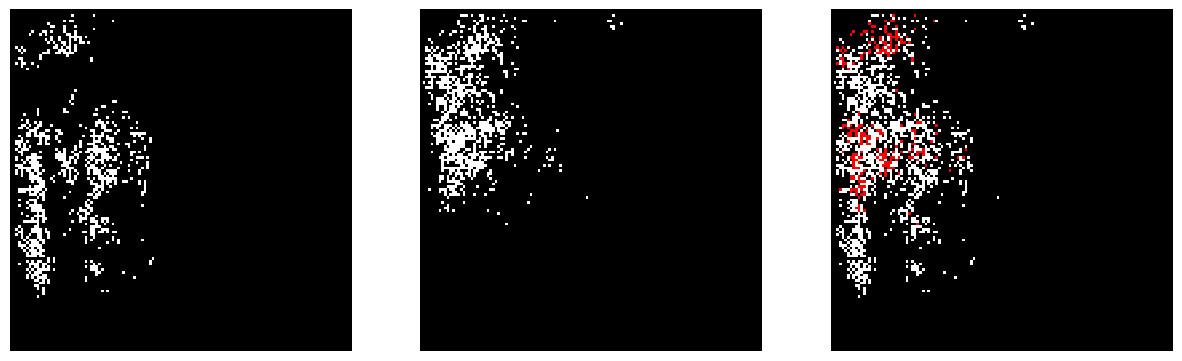

In [35]:
fig_fa_demo, axes_fa_demo = plt.subplots(1, 3, figsize=(15, 6))

axes_fa_demo[0].matshow(top_a, cmap='gray')
axes_fa_demo[1].matshow(top_b, cmap='gray')

cmap = colors.ListedColormap(['black', 'red', 'white'])
bounds = [0, 1, 2, 3]
norm = colors.BoundaryNorm(bounds, cmap.N)

intersect = (top_a == True) & (top_a == top_b)
union = (top_a == True) | (top_b  == True)
t = torch.zeros_like(top_a, dtype=int)
t[intersect] = 1
b_false = top_b == False
a_false = top_a == False
t[union & b_false] = 2
t[union & a_false] = 2
axes_fa_demo[2].matshow(t, cmap=cmap, norm=norm)

for ax in axes_fa_demo.flat:
    ax.axis('off')


plt.savefig(os.path.join(utils.FIGURES_PATH, f'demo_fa/top-k-{method1}'), bbox_inches=get_extent(fig_fa_demo, axes_fa_demo[0]))
plt.savefig(os.path.join(utils.FIGURES_PATH, f'demo_fa/top-k-{method2}'), bbox_inches=get_extent(fig_fa_demo, axes_fa_demo[1]))
plt.savefig(os.path.join(utils.FIGURES_PATH, 'demo_fa/intersect'), bbox_inches=get_extent(fig_fa_demo, axes_fa_demo[2]))
plt.show()